# Analyze neutralization data
This Python Jupyter notebook analyzes the neutralization data.

Import Python modules.
We use [neutcurve](https://jbloomlab.github.io/neutcurve/) to plot the neutralization curves:

In [1]:
import math
import re
import warnings

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import neutcurve
from neutcurve.colorschemes import CBPALETTE
from neutcurve.colorschemes import CBMARKERS

import pandas as pd

from plotnine import *

print(f"Using `neutcurve` version {neutcurve.__version__}")

Using `neutcurve` version 0.5.1


Specify input / output files:

In [2]:
# input files
fracinfect_file = 'results/fracinfect.csv'
serum_info_file = 'serum_info.csv'

# output files
all_replicate_curves = 'results/all_neut_replicates.pdf'
all_neut_by_sera_curves = 'results/all_neut_by_sera.pdf'
all_fit_params = 'results/all_fit_params.csv'
all_neut_titers = 'results/all_neut_titers.csv'

Read in the neutralization data, dropping sera labeled as "Nothing":

In [3]:
print(f"Reading neutralization data from {fracinfect_file}")
fracinfect = pd.read_csv(fracinfect_file)

# Input data restarts replicate numbers for each new date. Instead label replicates as:
#  - replicate_on_date: number of the replicate on that specific date
#  - replicate_with_date: number of replicate on that date suffixed by date
#  - replicate_all_dates: number replicates sequentially across all dates
fracinfect = (
    fracinfect
    .query('serum != "Nothing"')
    .assign(replicate_with_date=lambda x: x['replicate'].astype(str) +
                                          ' (' + x['date'] + ')')
    .rename(columns={'replicate': 'replicate_on_date'})
    )
fracinfect = (
    fracinfect
    .merge(fracinfect
           .sort_values('date')
           [['serum', 'virus', 'replicate_with_date']]
           .drop_duplicates()
           .assign(replicate_all_dates=lambda x: x.groupby(['serum', 'virus'])
                                                  ['replicate_with_date']
                                                  .transform('cumcount') + 1
                   ),
            how='left', on=['serum', 'virus', 'replicate_with_date'], validate='many_to_one',
            )
    )

# make sure unique reading for each virus / serum / replicate / date
assert len(fracinfect) == len(fracinfect.groupby(['serum',
                                                  'virus',
                                                  'replicate_all_dates',
                                                  'concentration',
                                                  ]))

# order the viruses
virus_order = ['229E-1984', '229E-1992', '229E-2001', '229E-2008', '229E-2016']
fracinfect = (
    fracinfect
    .assign(virus=lambda x: pd.Categorical(x['virus'], virus_order, ordered=True))
    .sort_values(['serum', 'virus', 'date'])
    )

# show first few lines of data frame
display(HTML(fracinfect.head().to_html(index=False)))

Reading neutralization data from results/fracinfect.csv


serum,virus,replicate_on_date,concentration,fraction infectivity,date,replicate_with_date,replicate_all_dates
FH003MJ,229E-1984,1,0.100000,0.1043,2020-10-02,1 (2020-10-02),2
FH003MJ,229E-1984,1,0.033330,0.3108,2020-10-02,1 (2020-10-02),2
FH003MJ,229E-1984,1,0.011110,0.4958,2020-10-02,1 (2020-10-02),2
FH003MJ,229E-1984,1,0.003704,1.1130,2020-10-02,1 (2020-10-02),2
FH003MJ,229E-1984,1,0.001235,0.7447,2020-10-02,1 (2020-10-02),2


Get information on sera:

In [4]:
serum_info = (
    pd.read_csv(serum_info_file)
    .assign(collection_date=lambda x: pd.to_datetime(x['collection_date']),
            collection_year=lambda x: x['collection_date'].dt.year +
                                      (x['collection_date'].dt.dayofyear - 1) / 365,
            collection_year_round=lambda x: x['collection_year']
                                            .map(lambda y: str(int(round(y)))
                                                           if pd.notnull(y)
                                                           else 'unknown'),
            serum_year=lambda x: x.apply(lambda r: f"{r['serum']} ({r['collection_year_round']})",
                                         axis=1)
            )
    .sort_values('collection_date')
    )
    
assert len(serum_info) == serum_info['serum'].nunique()
print(f"Read information for {len(serum_info)} sera")

sera_lacking_info = set(fracinfect['serum']) - set(serum_info['serum'])
if sera_lacking_info:
    raise ValueError(f"lacking information for these sera: {sera_lacking_info}")

# show first few lines of sera information data frame:
display(HTML(serum_info.head().to_html(index=False)))

Read information for 47 sera


serum,collection_date,age,category,notes,collection_year,collection_year_round,serum_year
SD85_1,1985-01-03,27,human,sera,1985.005479,1985,SD85_1 (1985)
SD85_2,1985-01-08,20,human,sera,1985.019178,1985,SD85_2 (1985)
SD85_3,1985-04-10,26,human,sera,1985.271233,1985,SD85_3 (1985)
SD85_4,1985-04-11,23,human,sera,1985.273973,1985,SD85_4 (1985)
SD85_5,1985-04-18,23,human,sera,1985.293151,1985,SD85_5 (1985)


Use [neutcurve](https://jbloomlab.github.io/neutcurve/) to fit neutralization curves to all of the data:

In [5]:
fits = neutcurve.curvefits.CurveFits(
            data=fracinfect,
            replicate_col='replicate_all_dates',
            fixbottom=0,
            fixtop=1,
            )

Plot all curves for all replicates of all virus / serum combinations:

Saving plot to results/all_neut_replicates.pdf



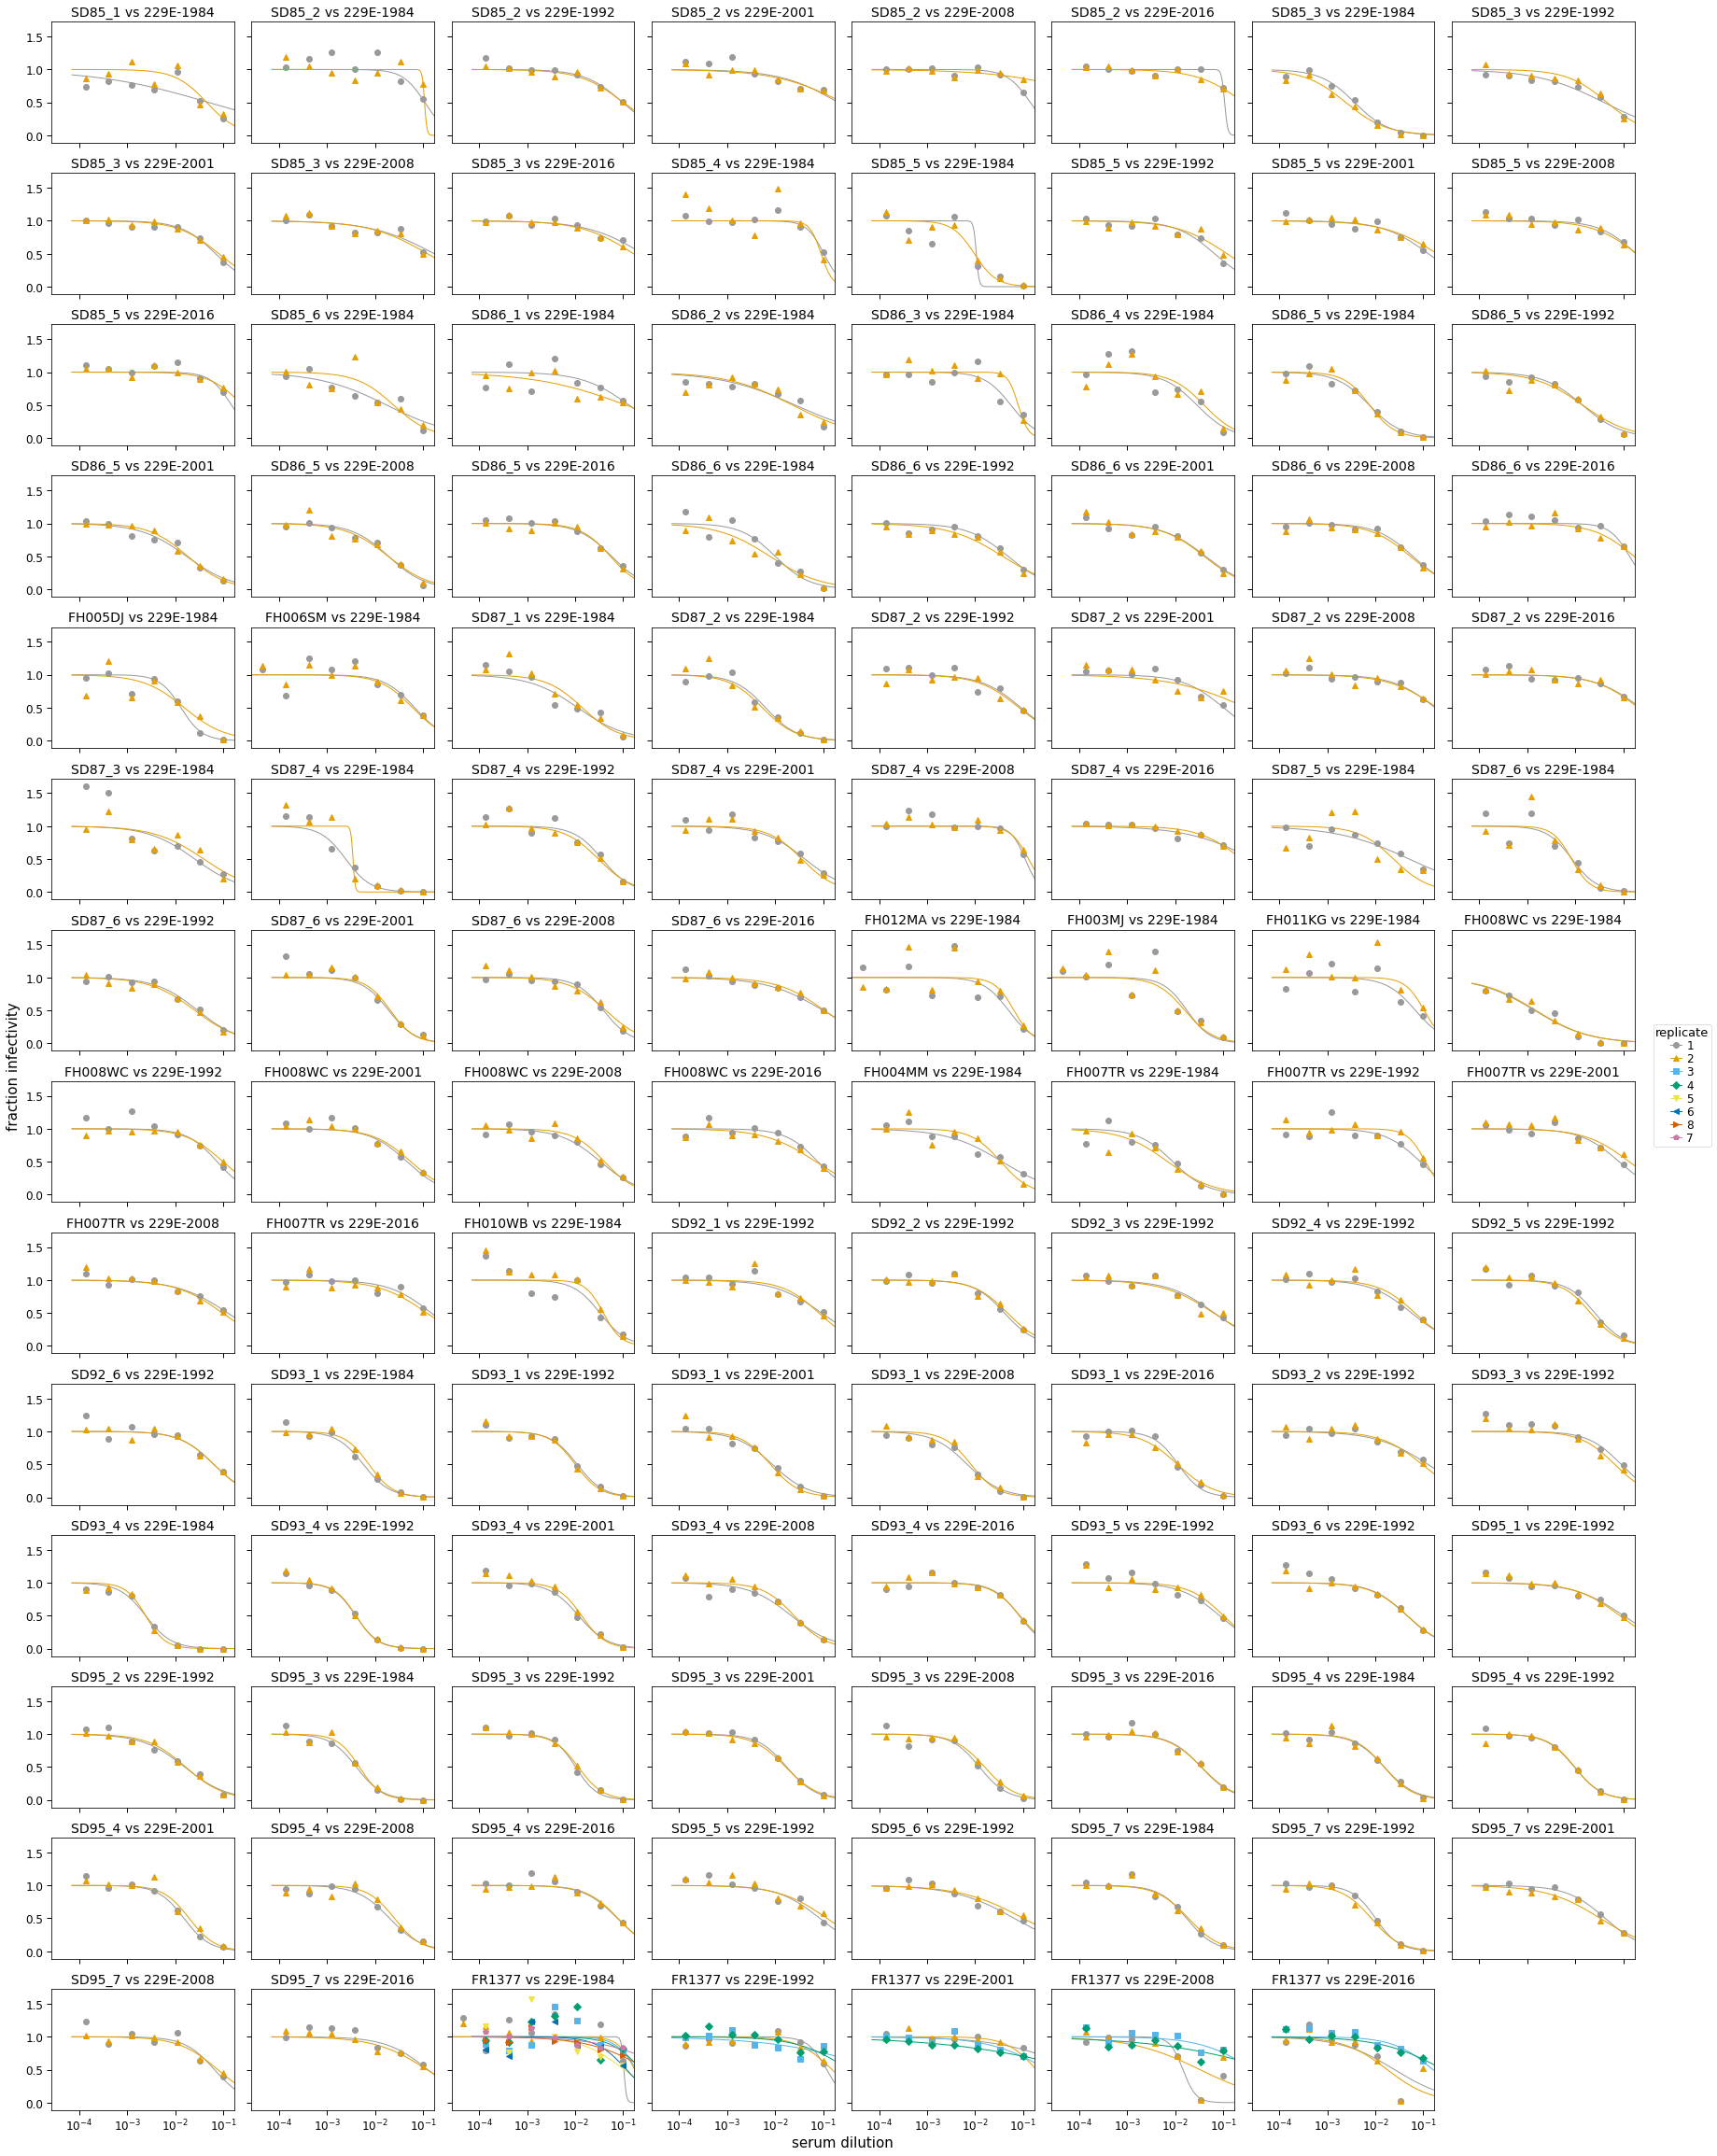

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # ignore fitting warnings
    fig, _ = fits.plotReplicates(ncol=8,
                                 legendtitle='replicate',
                                 xlabel='serum dilution',
                                 sera=serum_info['serum'],
                                 viruses=fracinfect['virus'].sort_values().unique(),
                                 )
    
print(f"Saving plot to {all_replicate_curves}\n")
fig.savefig(all_replicate_curves)
fig.tight_layout()
display(fig)
plt.close(fig)

Make a plot showing all viruses against each sera:

/fh/fast/bloom_j/software/miniconda3/envs/CoV_229E_antigenic_drift/lib/python3.8/site-packages/neutcurve/hillcurve.py:689: RuntimeWarning: invalid value encountered in power


Saving plot to results/all_neut_by_sera.pdf



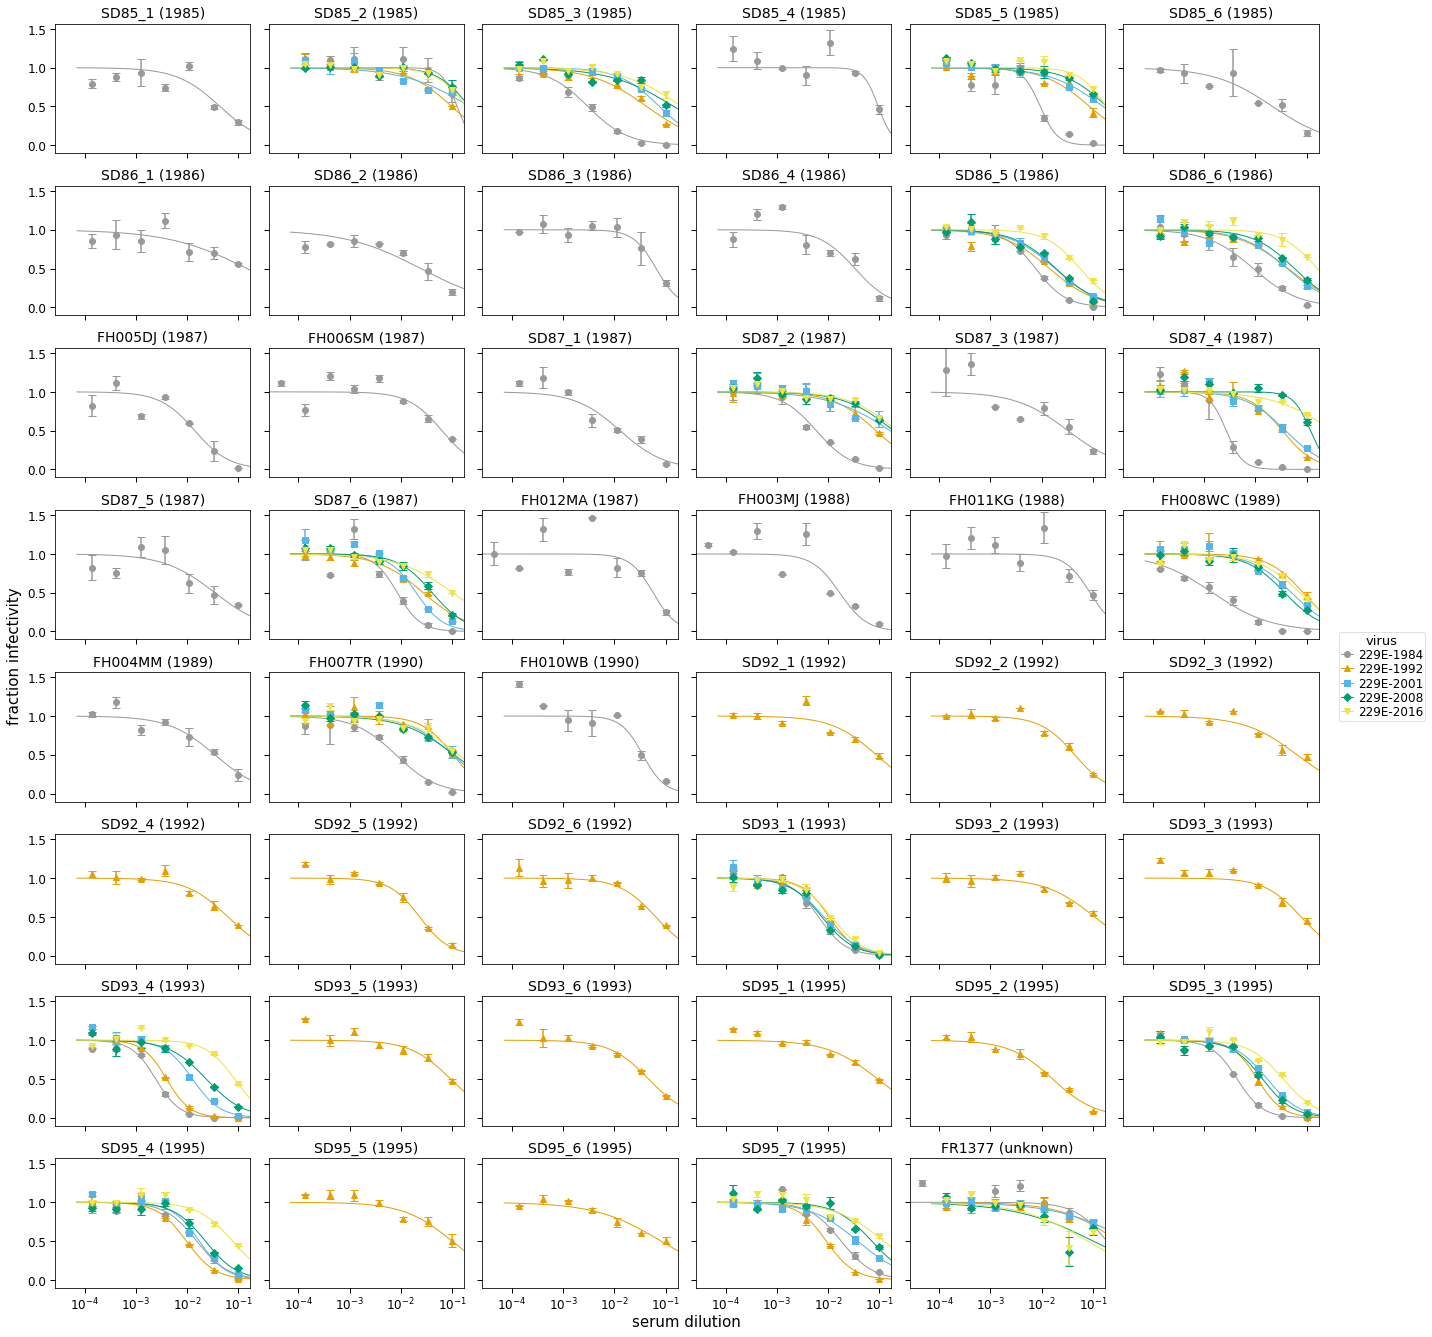

In [7]:
fig, _ = fits.plotSera(xlabel='serum dilution',
                       ncol=6,
                       legendtitle='virus',
                       viruses=fracinfect['virus'].sort_values().unique(),
                       sera=serum_info['serum'],
                       titles=serum_info['serum_year'],
                       )

print(f"Saving plot to {all_neut_by_sera_curves}\n")
fig.savefig(all_neut_by_sera_curves)
fig.tight_layout()
display(fig)
plt.close(fig)

Write all of the fit parameters to a file:

In [8]:
print(f"Writing all fit parameters to {all_fit_params}; first few lines also printed below:")

display(HTML(fits.fitParams().head().to_html(index=False)))

fits.fitParams().to_csv(all_fit_params, index=False)

Writing all fit parameters to results/all_fit_params.csv; first few lines also printed below:


serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,midpoint,slope,top,bottom
FH003MJ,229E-1984,average,2,0.016790,interpolated,0.0168,0.016790,1.635237,1,0
FH004MM,229E-1984,average,2,0.034620,interpolated,0.0346,0.034620,0.963866,1,0
FH005DJ,229E-1984,average,2,0.014059,interpolated,0.0141,0.014059,1.289468,1,0
FH006SM,229E-1984,average,2,0.063402,interpolated,0.0634,0.063402,1.324233,1,0
FH007TR,229E-1984,average,2,0.008009,interpolated,0.00801,0.008009,1.074526,1,0


Get neutralization titers, and merge them with information on the sera:

In [9]:
neut_titers = (
    fits.fitParams()
    .assign(neut_titer=lambda x: 1 / x['ic50'])
    .assign(is_upper_bound=lambda x: x['ic50_bound'].map({'lower': True,
                                                          'interpolated': False}))
    [['serum', 'virus', 'neut_titer', 'is_upper_bound']]
    .merge(serum_info[['serum', 'serum_year', 'collection_date', 'collection_year', 'age']],
           how='left', validate='many_to_one', on='serum')
    )

print(f"Writing neut titers to {all_neut_titers}; first few lines also printed below:")

display(HTML(neut_titers.head().to_html(index=False, float_format='%.1f')))

neut_titers.to_csv(all_neut_titers, index=False, float_format='%.1f')

Writing neut titers to results/all_neut_titers.csv; first few lines also printed below:


serum,virus,neut_titer,is_upper_bound,serum_year,collection_date,collection_year,age
FH003MJ,229E-1984,59.6,False,FH003MJ (1988),1987-11-09,1987.9,<40
FH004MM,229E-1984,28.9,False,FH004MM (1989),1989-06-26,1989.5,<40
FH005DJ,229E-1984,71.1,False,FH005DJ (1987),1986-10-06,1986.8,66
FH006SM,229E-1984,15.8,False,FH006SM (1987),1986-12-20,1987.0,<40
FH007TR,229E-1984,124.9,False,FH007TR (1990),1989-08-29,1989.7,28


Now for plotting annotate neut titers with information about:
 - virus year
 - the "closest" virus for each sera, which is the most recent virus isolated no later than the sera collection year

In [10]:
def get_virus_year(virus):
    m = re.fullmatch('229E\-(?P<year>\d{4})', virus)
    if not m:
        raise ValueError(f"cannot match virus year in {virus}")
    else:
        return int(m.group('year'))

annotated_neut_titers = (
    neut_titers
    .assign(virus_year=lambda x: x['virus'].map(get_virus_year))
    )

annotated_neut_titers = (
    annotated_neut_titers
    .merge(annotated_neut_titers.sort_values('collection_year')
                                .query('collection_date.dt.year >= virus_year')
                                .groupby('serum', as_index=False)
                                .aggregate(closest_virus_year=pd.NamedAgg('virus_year', 'last'),
                                           closest_virus=pd.NamedAgg('virus', 'last')
                                           ),
           how='left', on='serum')
    .assign(closest_virus_year=lambda x: x['closest_virus_year'].astype('Int64'))
    )

Get lower bound for neutralization titers and make sure consistent across all samples:

In [11]:
titer_lower_bound = neut_titers.query('is_upper_bound')['neut_titer'].min()

print(f"The lower bound on measurable neutralization titers is {titer_lower_bound}")

assert (neut_titers.query('is_upper_bound')['neut_titer'] == titer_lower_bound).all()

The lower bound on measurable neutralization titers is 10.0


Set titer cutoff for samples that are analyzed against additional years:

In [12]:
titer_cutoff = 90

Plot distribution of titers for each sera against it's "closest" virus:


There are 27 sera with a most recent closest virus of 229E-1984.
These sera were collected between 1985 and 1990.
9 of the 27 sera have neut titers >90:


serum,virus,collection_date,age,neut_titer,is_upper_bound,sera_range
FH008WC,229E-1984,1989-02-06,unknown,684.4,False,1985-1990
SD87_4,229E-1984,1987-03-16,22,370.3,False,1985-1990
SD85_3,229E-1984,1985-04-10,26,330.2,False,1985-1990
SD87_2,229E-1984,1987-01-22,24,170.5,False,1985-1990
SD86_5,229E-1984,1986-03-10,35,131.7,False,1985-1990
FH007TR,229E-1984,1989-08-29,28,124.9,False,1985-1990
SD87_6,229E-1984,1987-04-30,29,117.0,False,1985-1990
SD86_6,229E-1984,1986-04-10,32,109.7,False,1985-1990
SD85_5,229E-1984,1985-04-18,23,106.9,False,1985-1990



There are 19 sera with a most recent closest virus of 229E-1992.
These sera were collected between 1992 and 1995.
5 of the 19 sera have neut titers >90:


serum,virus,collection_date,age,neut_titer,is_upper_bound,sera_range
SD93_4,229E-1992,1993-03-15,20,252.5,False,1992-1995
SD95_7,229E-1992,1995-04-07,12,108.1,False,1992-1995
SD95_4,229E-1992,1995-02-28,unknown,103.5,False,1992-1995
SD93_1,229E-1992,1993-01-22,unknown,95.1,False,1992-1995
SD95_3,229E-1992,1995-02-21,unknown,91.6,False,1992-1995



Distribution of titers of sera against its most recent closest virus:


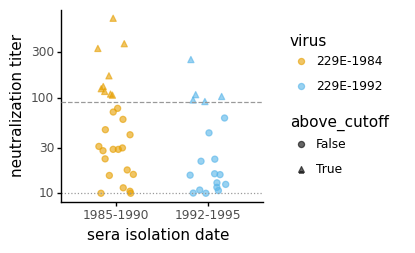

In [13]:
closest_virus_df = pd.DataFrame()
for closest_virus_year, df in annotated_neut_titers.groupby('closest_virus_year'):
    assert df['closest_virus'].nunique() == 1, df['closest_virus'].unique()
    closest_virus = df['closest_virus'].unique().tolist()[0]
    earliest_sera = df['collection_year'].round().sort_values().astype(int).tolist()[0]
    latest_sera = df['collection_year'].round().sort_values().astype(int).tolist()[-1]
    
    df_closest = (
        df
        .query('virus_year == @closest_virus_year')
        [['serum', 'virus', 'collection_date', 'age', 'neut_titer', 'is_upper_bound']]
        .sort_values('neut_titer', ascending=False)
        .assign(sera_range=f"{earliest_sera}-{latest_sera}",
                titer_to_closest_virus=lambda x: x['neut_titer'],
                closest_virus=closest_virus)
        )
    closest_virus_df = closest_virus_df.append(df_closest)
    
    above_cutoff = df_closest.query('neut_titer > @titer_cutoff')
    
    print(f"\nThere are {len(df_closest)} sera with a most recent closest virus of {closest_virus}.\n"
          f"These sera were collected between {earliest_sera} and {latest_sera}.\n"
          f"{len(above_cutoff)} of the {len(df_closest)} sera have neut titers >{titer_cutoff}:")
    display(HTML(above_cutoff
                 .drop(columns=['closest_virus', 'titer_to_closest_virus'])
                 .to_html(index=False, float_format='%.1f')
                 ))
    
print('\nDistribution of titers of sera against its most recent closest virus:')
p = (ggplot(closest_virus_df.assign(above_cutoff=lambda x: x['neut_titer'] > titer_cutoff)) +
     aes('sera_range', 'neut_titer', color='virus', shape='above_cutoff') +
     geom_jitter(height=0, width=0.2, size=2,
                 alpha=0.6, random_state=1) +
     theme_classic() +
     theme(figure_size=(1.3 * closest_virus_df['virus'].nunique(), 2.5),
           ) +
     scale_y_log10(name='neutralization titer') +
     scale_color_manual(values=CBPALETTE[1:]) +
     xlab('sera isolation date') +
     geom_hline(yintercept=titer_lower_bound, linetype='dotted', color=CBPALETTE[0]) +
     geom_hline(yintercept=titer_cutoff, linetype='dashed', color=CBPALETTE[0])
     )
_ = p.draw()

Now plot neutralization titers as a function of virus isolation date for all viruses with a titer against the 1984 virus of at least 100.

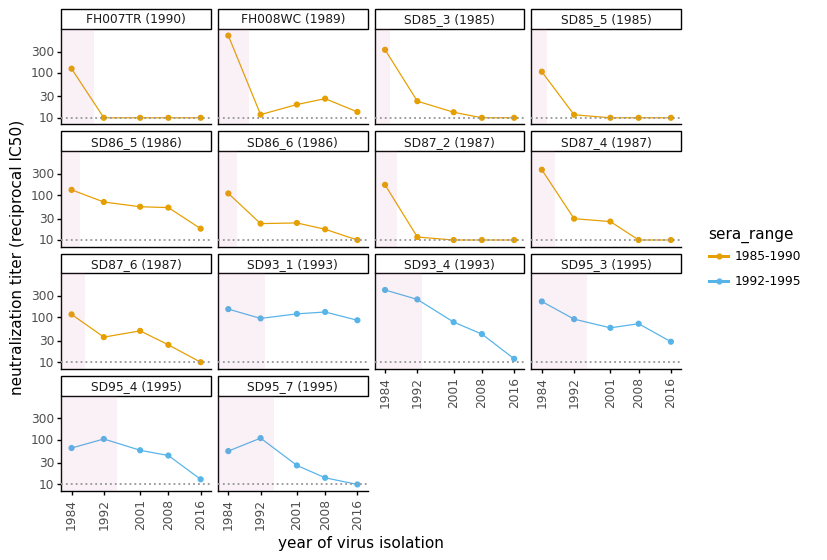

In [14]:
df = (annotated_neut_titers
      .merge(closest_virus_df[['serum', 'closest_virus', 'sera_range', 'titer_to_closest_virus']],
             on='serum')
      .query('titer_to_closest_virus > @titer_cutoff')
      )

ncol = 4
nfacets = df['serum_year'].nunique()
nrow = math.ceil(nfacets / ncol)

p = (
    ggplot(df) +
    aes(x='virus_year', y='neut_titer', color='sera_range') +
    geom_point() +
    geom_line() +
    facet_wrap('~ serum_year',
               ncol=ncol,
               nrow=nrow) +
    scale_y_log10(name='neutralization titer (reciprocal IC50)',
                  expand=(0.08, 0),
                  ) +
    scale_x_continuous(name='year of virus isolation',
                      breaks=df['virus_year'].sort_values().unique(),
                      expand=(0.08, 0),
                      ) +
    theme_classic() +
    geom_rect(data=df[['serum_year', 'collection_year']].drop_duplicates(),
              mapping=aes(xmax='collection_year'),
              inherit_aes=False,
              xmin=0, ymin=0, ymax=100, fill=CBPALETTE[-1], alpha=0.1) +
    scale_color_manual(values=CBPALETTE[1:]) +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(2 * ncol, 1.5 * nrow)) +
    geom_hline(yintercept=titer_lower_bound, linetype='dotted', color=CBPALETTE[0], size=0.75)
    )

_ = p.draw()